In [2]:
import ee
import geemap
import folium

# Authenticate and initialize Google Earth Engine (only required once)
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
# Define your sugarcane farm polygon (Replace with actual coordinates)
polygon = ee.Geometry.Polygon([
    [[79.90101086, 27.69192364], 
     [79.90184435, 27.69178079], 
     [79.90200853, 27.69202635], 
     [79.90126732, 27.69236525], 
     [79.90101086, 27.69192364]]
])

In [4]:
# Load Landsat 8 Surface Temperature data
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(polygon) \
    .filterDate("2023-01-01", "2023-12-31") \
    .sort("CLOUD_COVER") \
    .first()  # Take the least cloudy image

In [5]:
# Convert DN values to Brightness Temperature (BT) using Thermal Band 10
radiance = landsat8.select("ST_B10")  # Surface Temperature Band

# Convert temperature from Kelvin to Celsius
lst_celsius = radiance.subtract(273.15)

# Clip temperature data to the sugarcane farm polygon
lst_clipped = lst_celsius.clip(polygon)

# Define color gradient for visualization
temp_viz_params = {
    "min": 20,  # Min expected temperature in Celsius
    "max": 40,  # Max expected temperature in Celsius
    "palette": ["blue", "cyan", "green", "yellow", "red"]
}

In [6]:
# Create a folium map centered around the polygon
map_center = polygon.centroid().coordinates().getInfo()[::-1]  # Get lat, lon
m = geemap.Map(center=map_center, zoom=14)

# Add the temperature layer to the map
m.addLayer(lst_clipped, temp_viz_params, "Land Surface Temperature")

# Add the polygon boundary
m.addLayer(polygon, {"color": "black"}, "Sugarcane Farm")

Landsat 8 image found for 2025-02-09.
Available bands: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']


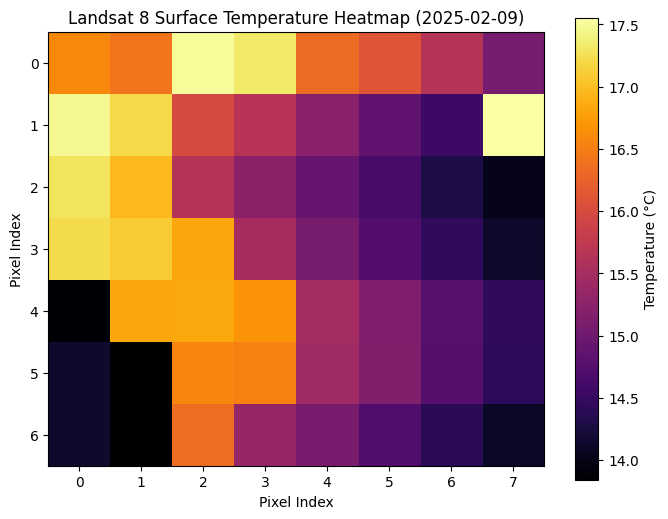

In [30]:
import ee
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Authenticate and initialize Google Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# Expand Sugarcane Farm Polygon Slightly
polygon = ee.Geometry.Polygon([
    [[79.90101086, 27.69192364], 
     [79.90184435, 27.69178079], 
     [79.90200853, 27.69202635], 
     [79.90126732, 27.69236525], 
     [79.90101086, 27.69192364]]
]).buffer(90)  # Expanding by 150 meters to ensure Landsat pixel coverage

# Search Landsat images in the past 30 days with low cloud cover
search_start = (datetime.date.today() - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
search_end = datetime.date.today().strftime("%Y-%m-%d")

landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(polygon) \
    .filterDate(search_start, search_end) \
    .filterMetadata("CLOUD_COVER", "less_than", 20) \
    .sort("CLOUD_COVER", False)

landsat = landsat_collection.first()

# Check if an image is found
if landsat.getInfo():
    landsat_date_str = landsat.get("DATE_ACQUIRED").getInfo()
    print(f"Landsat 8 image found for {landsat_date_str}.")

    # Print available bands
    available_bands = landsat.bandNames().getInfo()
    print(f"Available bands: {available_bands}")

    # Check if ST_B10 exists
    if "ST_B10" in available_bands:
        raw_temp = landsat.select("ST_B10").multiply(0.00341802).add(149.0).subtract(273.15)

        # Sample temperature data inside the polygon
        temperature_pixels = raw_temp.sample(
            region=polygon,
            scale=30,  # Landsat 8 resolution
            numPixels=500,  # Requesting enough pixels
            seed=42
        ).getInfo()

        # Extract temperature values
        if temperature_pixels and "features" in temperature_pixels:
            temp_values = [feat["properties"]["ST_B10"] for feat in temperature_pixels["features"]]

            # Ensure we have at least 50 valid pixels
            if len(temp_values) < 50:
                print("⚠️ Not enough valid temperature pixels were found.")
            else:
                # Determine a rectangular shape close to square
                num_rows = int(np.floor(np.sqrt(len(temp_values))))
                num_cols = int(np.ceil(len(temp_values) / num_rows))
                
                # Fill missing values with NaN if needed
                while len(temp_values) < (num_rows * num_cols):
                    temp_values.append(np.nan)

                # Convert temperature data into a proper 2D array
                temp_array = np.array(temp_values).reshape(num_rows, num_cols)

                # Plot the heatmap
                plt.figure(figsize=(8, 6))
                plt.imshow(temp_array, cmap="inferno", interpolation="nearest")
                plt.colorbar(label="Temperature (°C)")
                plt.title(f"Landsat 8 Surface Temperature Heatmap ({landsat_date_str})")
                plt.xlabel("Pixel Index")
                plt.ylabel("Pixel Index")
                plt.show()
        else:
            print("⚠️ No valid temperature data found in the region.")
    else:
        print("⚠️ ST_B10 band is missing from this Landsat image.")
else:
    print(f"⚠️ No Landsat 8 image found from {search_start} to {search_end}.")


Thermal Band DN - Min: 45699.0, Max: 48577.0
TOA Radiance - Min: 15.372605799999999, Max: 16.3344334
Brightness Temperature - Min: 335.31859410378445, Max: 340.45789666939277
Raw LST - Min: 62.185803799952794, Max: 67.32563795530962
Final LST - Min: 62.185803799952794, Max: 67.32563795530962


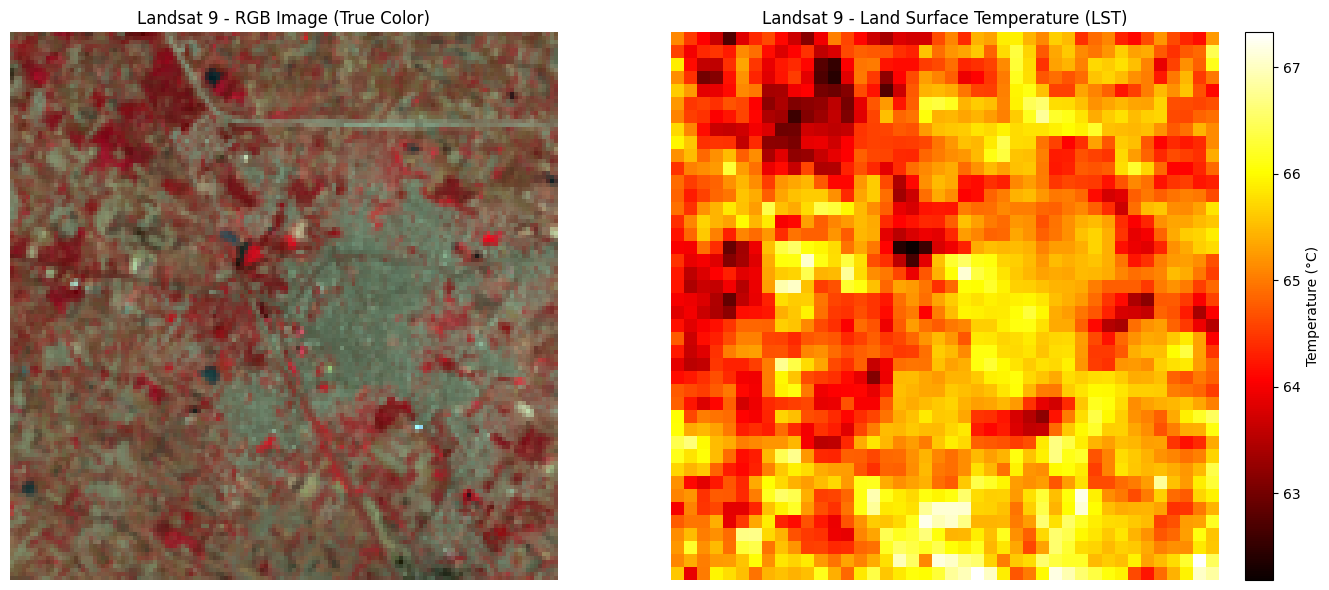

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# --- Load Landsat 9 RGB Image ---
rgb_file = "/home/smurfs/agri_info2/Images/landsat/L9_29.3080N_78.5033E_20240417_20250225_203540.tif"
lst_file = "/home/smurfs/agri_info2/Images/landsat/L9_thermal_29.3080N_78.5033E_20240417_20250225_203545.tif"

# --- Step 1: Load RGB Image (Bands 4,3,2 for True Color) ---
with rasterio.open(rgb_file) as src:
    red = src.read(4).astype(float)
    green = src.read(3).astype(float)
    blue = src.read(2).astype(float)

# Normalize & Apply Gamma Correction for RGB Enhancement
def normalize(img):
    return (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))

red = normalize(red)
green = normalize(green)
blue = normalize(blue)

rgb_image = np.dstack((red, green, blue))
rgb_image = exposure.adjust_gamma(rgb_image, gamma=0.8)  # Adjust gamma for better visibility

# --- Step 2: Load Landsat 9 Thermal Band 10 (TIRS 1) ---
with rasterio.open(lst_file) as src:
    thermal_dn = src.read(1).astype(float)  # Read Thermal Band 10

# --- Debug: Print Min/Max DN Values ---
print(f"Thermal Band DN - Min: {np.nanmin(thermal_dn)}, Max: {np.nanmax(thermal_dn)}")

# --- Step 3: Convert DN to TOA Radiance ---
ML = 0.0003342  # Radiance Scaling Factor (Check MTL.txt)
AL = 0.1        # Radiance Additive Offset

toa_radiance = ML * thermal_dn + AL

# --- Debug: Print Min/Max Radiance Values ---
print(f"TOA Radiance - Min: {np.nanmin(toa_radiance)}, Max: {np.nanmax(toa_radiance)}")

# --- Step 4: Convert TOA Radiance to Brightness Temperature (BT) ---
K1 = 774.8853  # Planck constant for Band 10
K2 = 1321.0789

bt_kelvin = K2 / (np.log((K1 / toa_radiance) + 1))

# --- Debug: Print Min/Max BT Values ---
print(f"Brightness Temperature - Min: {np.nanmin(bt_kelvin)}, Max: {np.nanmax(bt_kelvin)}")

# --- Step 5: Apply Emissivity Correction to Get LST ---
λ = 10.9e-6  # Wavelength for Band 10
c2 = 1.4388  # Planck's second constant
ε = 0.98  # Assume emissivity for vegetation

lst_celsius = bt_kelvin / (1 + (λ * bt_kelvin / c2) * np.log(ε)) - 273.15  # Convert to °C

# --- Debug: Print Min/Max LST Values Before Masking ---
print(f"Raw LST - Min: {np.nanmin(lst_celsius)}, Max: {np.nanmax(lst_celsius)}")

# --- Fix: Mask Invalid Values ---
lst_celsius[lst_celsius < -50] = np.nan  # Remove unreasonable values
lst_celsius[lst_celsius > 80] = np.nan  # Remove high outliers

# --- Debug: Print Min/Max LST Values After Masking ---
print(f"Final LST - Min: {np.nanmin(lst_celsius)}, Max: {np.nanmax(lst_celsius)}")

# --- Step 6: Plot RGB and LST Side-by-Side ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot RGB Image
ax[0].imshow(rgb_image)
ax[0].set_title("Landsat 9 - RGB Image (True Color)")
ax[0].axis("off")

# Plot LST with Corrected Scale
cmap = plt.get_cmap("hot")
lst_plot = ax[1].imshow(lst_celsius, cmap=cmap, vmin=np.nanmin(lst_celsius), vmax=np.nanmax(lst_celsius))
ax[1].set_title("Landsat 9 - Land Surface Temperature (LST)")
ax[1].axis("off")
cbar = plt.colorbar(lst_plot, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Temperature (°C)")

plt.tight_layout()
plt.show()
